In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage.morphology import label, remove_small_objects
from skimage.measure import regionprops
from skimage.io import imread
from skimage.color import label2rgb

In [5]:
def plot(image: np.ndarray, title: str=None, zlimit: bool=True, figsize: tuple=(8, 8), **kwargs) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

# Load image and optionally flatten and save (for manual masking)

[Tue, 28 Mar 2023 13:09:39] [INFO    ] [topostats] Extracting image from Flat\20230126_KPN005.0_00024.spm
[Tue, 28 Mar 2023 13:09:39] [INFO    ] [topostats] Loading image from : Flat\20230126_KPN005.0_00024.spm
[Tue, 28 Mar 2023 13:09:39] [INFO    ] [topostats] [20230126_KPN005.0_00024] : Loaded image from : Flat\20230126_KPN005.0_00024.spm
[Tue, 28 Mar 2023 13:09:39] [INFO    ] [topostats] [20230126_KPN005.0_00024] : Extracted channel Height
[Tue, 28 Mar 2023 13:09:39] [INFO    ] [topostats] [20230126_KPN005.0_00024] : Pixel to nm scaling : 5.992138671875


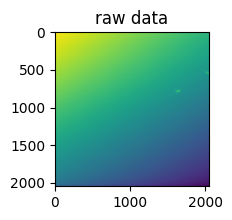

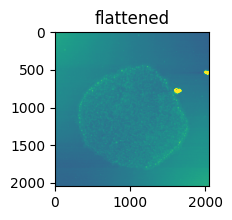

In [6]:
file = Path('./Flat/20230126_KPN005.0_00024.spm')
# Load the data
loadscans = LoadScans([file], channel='Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plot(image_raw, title='raw data', zlimit=False, figsize=(2, 2))
image = image_raw.copy()

# Optionally flatten image
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False},
    quiet=True
)
filters.filter_image()
image = filters.images['zero_average_background']
plot(image, title='flattened', figsize=(2, 2))

# Optionally save the image for manual masking externally
out_dir = Path('./manual_masking_images/')
out_dir.mkdir(exist_ok=True)
plt.imsave(out_dir / 'to_be_masked.png', image)

(2048, 2048)


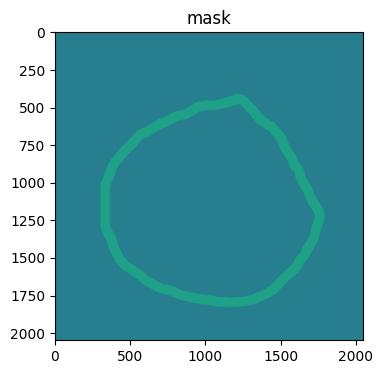

In [7]:
# Load mask
mask_path = Path('./manual_masking_images/project-1-at-2023-03-28-13-06-f99ea17e.png')
mask = imread(mask_path)
mask = mask.astype(bool)
print(mask.shape)
plot(mask, title='mask', figsize=(4, 4))

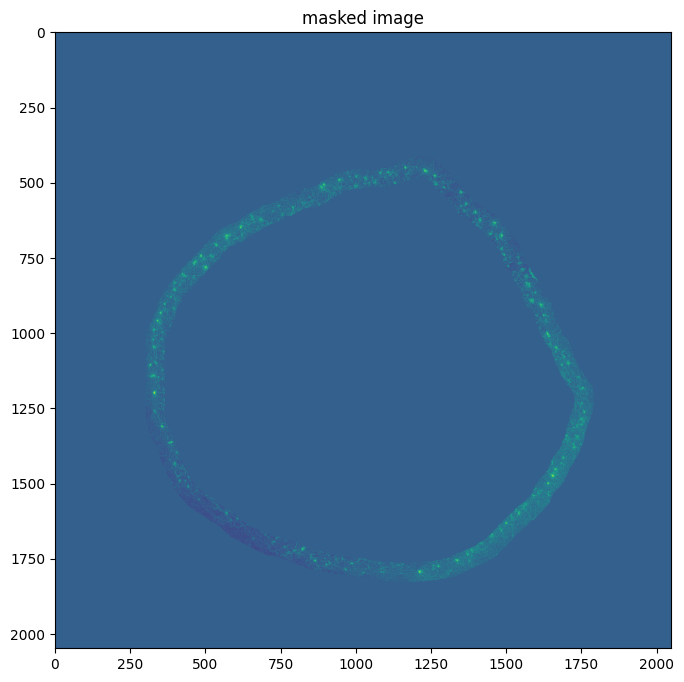

In [8]:
# Apply the mask to the image
masked = np.ma.masked_array(data=image, mask=np.invert(mask), fill_value=0).filled()
plot(masked, title='masked image', zlimit=False)

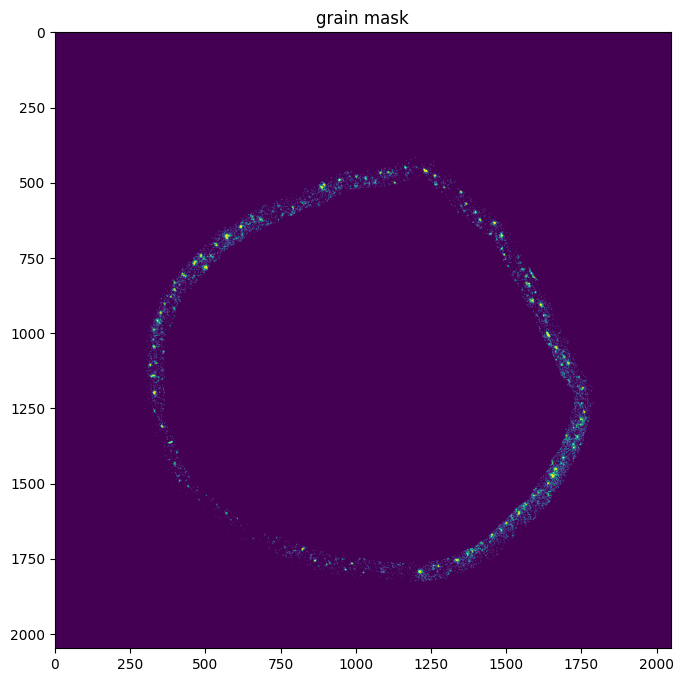

[False  True]


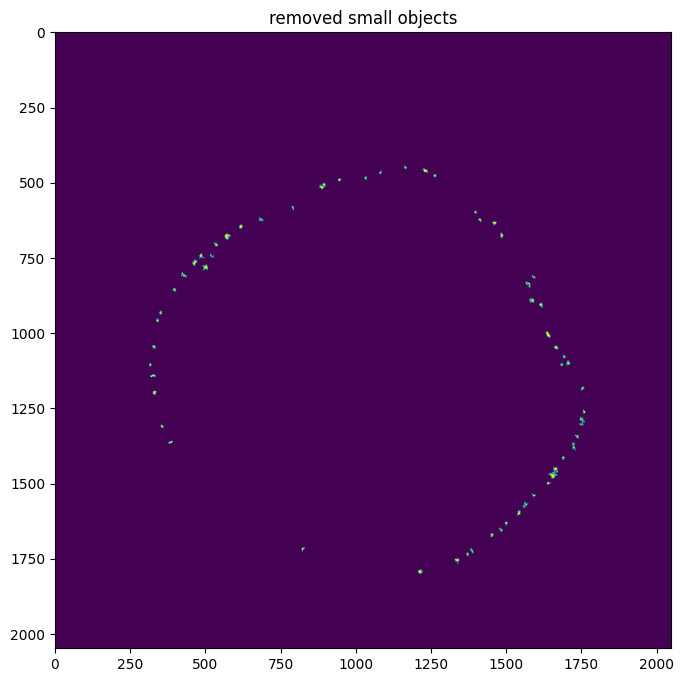

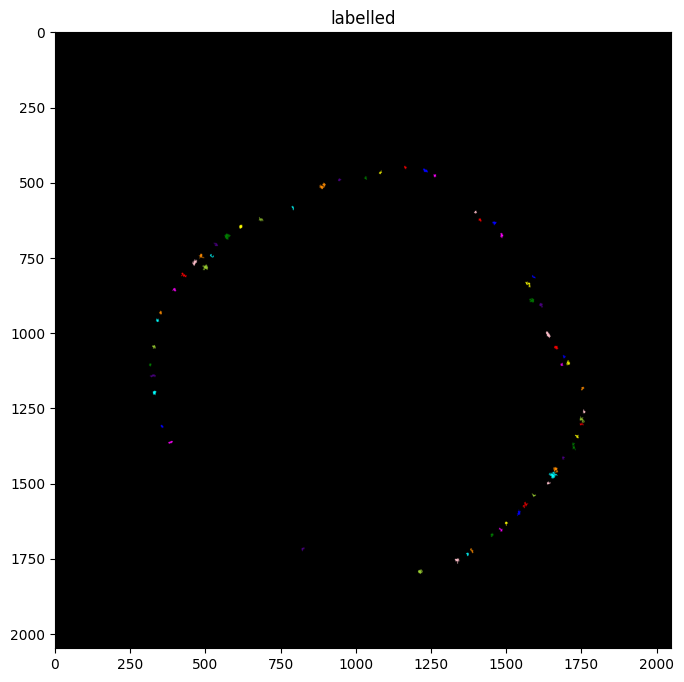

In [23]:
std_dev_multiplier = 5
threshold = np.mean(masked[masked != 0.0]) + np.std(masked) * std_dev_multiplier
grain_mask = masked > threshold
plot(grain_mask, title='grain mask', zlimit=False)
print(np.unique(grain_mask))
removed_small_objects = remove_small_objects(grain_mask, 50)
plot(removed_small_objects, title='removed small objects', zlimit=False)
labelled = label(removed_small_objects)
coloured_labels = label2rgb(labelled, bg_label=0)
plot(coloured_labels, title='labelled')

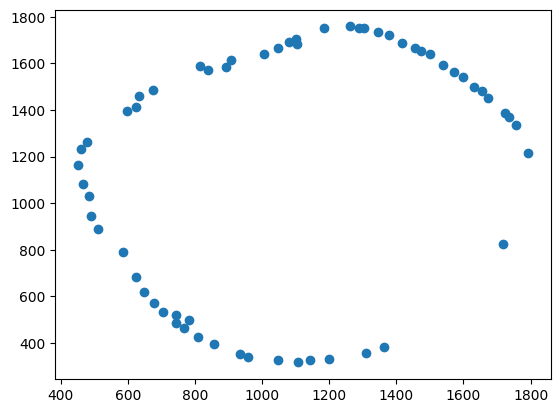

In [27]:
def get_points(binary_img) -> tuple:
    labelled = label(binary_img)
    regions = regionprops(labelled)
    points = np.ndarray((len(regions), 2))
    for props_index, props in enumerate(regions):
        points[props_index, :] = props.centroid

    return points

points = get_points(labelled)

centroid = np.array([np.mean(points[:, 0]), np.mean(points[:, 1])])

# Function to find angle of point from centroid
def angle(point, centroid):
    dx, dy = point - centroid
    return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)

# Sort the points based on their angles around the centroid
sorted = points[np.argsort([angle(point, centroid) for point in points])]


xs = np.append(sorted[:, 1], sorted[0, 1])
ys = np.append(sorted[:, 0], sorted[0, 0])

plt.scatter(sorted[:, 0], sorted[:, 1])

In [11]:
def is_clockwise(p_1: tuple, p_2: tuple, p_3: tuple) -> bool:
    """Function to determine if three points make a clockwise or counter-clockwise turn.

    Parameters
    ----------
    p_1: tuple
        First point to be used to calculate turn.
    p_2: tuple
        Second point to be used to calculate turn.
    p_3: tuple
        Third point to be used to calculate turn.

    Returns
    -------
    boolean
        Indicator of whether turn is clockwise.
    """

    rotation_matrix = np.array(((p_1[0], p_1[1], 1), (p_2[0], p_2[1], 1), (p_3[0], p_3[1], 1)))
    return not np.linalg.det(rotation_matrix) > 0

def get_triangle_height(base_point_1: np.array, base_point_2: np.array, top_point: np.array) -> float:
    """Returns the height of a triangle defined by the input point vectors.
    Parameters
    ----------
    base_point_1: np.ndarray
        a base point of the triangle, eg: [5, 3].

    base_point_2: np.ndarray
        a base point of the triangle, eg: [8, 3].

    top_point: np.ndarray
        the top point of the triangle, defining the height from the line between the two base points, eg: [6,10].

    Returns
    -------
    Float
        The height of the triangle - ie the shortest distance between the top point and the line between the two base points.
    """

    # Height of triangle = A/b = ||AB X AC|| / ||AB||
    a_b = base_point_1 - base_point_2
    a_c = base_point_1 - top_point
    return np.linalg.norm(np.cross(a_b, a_c)) / np.linalg.norm(a_b)

def ferets(edges: np.ndarray) -> float:
    """Returns the minimum and maximum feret diameters for a grain.
    These are defined as the smallest and greatest distances between
    a pair of callipers that are rotating around a 2d object, maintaining
    contact at all times.

    Parameters
    ----------
    edge_points: list
        a list of the vector positions of the pixels comprising the edge of the
        grain. Eg: [[0, 0], [1, 0], [2, 1]]
    Returns
    -------
    min_feret: float
        the minimum feret diameter of the grain
    max_feret: float
        the maximum feret diameter of the grain"""

    # Sort the vectors by x coordinate then y coordinate
    sorted_indices = np.lexsort((edges[:, 1], edges[:, 0]))
    sorted = edges[sorted_indices]

    # Construct upper and lower hulls for the edge points.
    upper_hull = []
    lower_hull = []
    for point in sorted:
        while len(lower_hull) > 1 and is_clockwise(lower_hull[-2], lower_hull[-1], point):
            lower_hull.pop()
        lower_hull.append(point)
        while len(upper_hull) > 1 and not is_clockwise(upper_hull[-2], upper_hull[-1], point):
            upper_hull.pop()
        upper_hull.append(point)
    
    upper_hull = np.array(upper_hull)
    lower_hull = np.array(lower_hull)

    # Create list of contact vertices for calipers on the antipodal hulls
    contact_points = []
    upper_index = 0
    lower_index = len(lower_hull) - 1
    min_feret = None
    while upper_index < len(upper_hull) - 1 or lower_index > 0:
        contact_points.append([lower_hull[lower_index, :], upper_hull[upper_index, :]])
        # If we have reached the end of the upper hull, continute iterating over the lower hull
        if upper_index == len(upper_hull) - 1:
            lower_index -= 1
            small_feret = get_triangle_height(
                np.array(lower_hull[lower_index + 1, :]),
                np.array(lower_hull[lower_index, :]),
                np.array(upper_hull[upper_index, :]),
            )
            if min_feret is None or small_feret < min_feret:
                min_feret = small_feret
        # If we have reached the end of the lower hull, continue iterating over the upper hull
        elif lower_index == 0:
            upper_index += 1
            small_feret = get_triangle_height(
                np.array(upper_hull[upper_index - 1, :]),
                np.array(upper_hull[upper_index, :]),
                np.array(lower_hull[lower_index, :]),
            )
            if min_feret is None or small_feret < min_feret:
                min_feret = small_feret
        # Check if the gradient of the last point and the proposed next point in the upper hull is greater than the gradient
        # of the two corresponding points in the lower hull, if so, this means that the next point in the upper hull
        # will be encountered before the next point in the lower hull and vice versa.
        # Note that the calculation here for gradients is the simple delta upper_y / delta upper_x > delta lower_y / delta lower_x
        # however I have multiplied through the denominators such that there are no instances of division by zero. The
        # inequality still holds and provides what is needed.
        elif (upper_hull[upper_index + 1, 1] - upper_hull[upper_index, 1]) * (
            lower_hull[lower_index, 0] - lower_hull[lower_index - 1, 0]
        ) > (lower_hull[lower_index, 1] - lower_hull[lower_index - 1, 1]) * (
            upper_hull[upper_index + 1, 0] - upper_hull[upper_index, 0]
        ):
            # If the upper hull is encoutnered first, increment the iteration index for the upper hull
            # Also consider the triangle that is made as the two upper hull vertices are colinear with the caliper
            upper_index += 1
            small_feret = get_triangle_height(
                np.array(upper_hull[upper_index - 1, :]),
                np.array(upper_hull[upper_index, :]),
                np.array(lower_hull[lower_index, :]),
            )
            if min_feret is None or small_feret < min_feret:
                min_feret = small_feret
        else:
            # The next point in the lower hull will be encountered first, so increment the lower hull iteration index.
            lower_index -= 1
            small_feret = get_triangle_height(
                np.array(lower_hull[lower_index + 1, :]),
                np.array(lower_hull[lower_index, :]),
                np.array(upper_hull[upper_index, :]),
            )

            if min_feret is None or small_feret < min_feret:
                min_feret = small_feret

    contact_points = np.array(contact_points)

    # Find the minimum and maximum distance in the contact points
    max_feret = None
    for point_pair in contact_points:
        dist = np.sqrt((point_pair[0, 0] - point_pair[1, 0]) ** 2 + (point_pair[0, 1] - point_pair[1, 1]) ** 2)
        if max_feret is None or max_feret < dist:
            max_feret = dist

    return min_feret, max_feret

In [12]:
def shoelace(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    area = 0
    for index in range(len(points)-1):
        matrix = points[index:index+2, :].T
        area += np.linalg.det(matrix)
    return np.round(area/2, 5)

def polygon_perimeter(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    perimeter = 0
    for i in range(len(points)-1):
        point1 = points[i, :]
        point2 = points[i+1, :]
        perimeter += np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    return perimeter

In [15]:
def curvature(xs: np.ndarray, ys: np.ndarray):
    extension_length = xs.shape[0]
    xs_extended = np.append(xs, xs)
    xs_extended = np.append(xs_extended, xs)
    ys_extended = np.append(ys, ys)
    ys_extended = np.append(ys_extended, ys)
    dx = np.gradient(xs_extended)
    dy = np.gradient(ys_extended)
    d2x = np.gradient(dx)
    d2y = np.gradient(dy)
    curv = np.abs(dx * d2y - d2x * dy) / (dx * dx + dy * dy)**1.5
    #curv = curv[extension_length:(len(curv)-extension_length)+1]
    return curv

In [13]:
def region_stats(labelled_image: np.ndarray, image: np.ndarray):

    region_props = regionprops(label_image=labelled_image)
    areas = np.zeros(len(region_props))
    volumes = np.zeros(len(region_props))
    max_heights = np.zeros(len(region_props))
    mean_heights = np.zeros(len(region_props))
    for props_index, props in enumerate(region_props):
        areas[props_index] = props.area
        region_points = np.where(labelled_image == props.label)
        region_values = image[region_points]
        volume = np.sum(region_values)
        volumes[props_index] = volume
        max_heights[props_index] = np.max(region_values)
        mean_heights[props_index] = np.mean(region_values)

    return {
        'areas': areas,
        'volumes': volumes,
        'max_heights': max_heights,
        'mean_heights': mean_heights,
        'number_of_regions': len(region_props),
    }

In [29]:
#Output statistics

MICRON_SCALING_FACTOR = 0.001
P_TO_MICRON = p_to_nm * MICRON_SCALING_FACTOR

print('Image:',file)

print('- molecule stats -')
area = shoelace(sorted)* P_TO_MICRON**2
print(f'area: {area:.2f} μm^2')
perimeter = polygon_perimeter(sorted)* P_TO_MICRON
print(f'perimeter: {perimeter:.2f} μm')
min_feret, max_feret = ferets(sorted)
print(f'min_feret: {min_feret* P_TO_MICRON:.2f} μm | max_feret: {max_feret* P_TO_MICRON:.2f} μm')
regionstats = region_stats(labelled_image=labelled, image=image)
curv = curvature(xs,ys)
print(f'mean_curvature: {np.mean(curv)}')
print(f'sum_curvature: {np.sum(curv)}')

print('- node stats -')
num_perimeter_nodes = sorted.shape[0]
print(f'number of nodes in perimeter: {num_perimeter_nodes}')
print(f'node areas | min: {np.min(regionstats["areas"]* p_to_nm**2):.2f} nm^2 max: {np.max(regionstats["areas"]* p_to_nm**2):.2f} nm^2 mean: {np.mean(regionstats["areas"]* p_to_nm**2):.2f} nm^2')
print(f'node volumes | min: {np.min(regionstats["volumes"]* p_to_nm**2):.2f} nm^3 max: {np.max(regionstats["volumes"]* p_to_nm**2):.2f} nm^3 mean: {np.mean(regionstats["volumes"]* p_to_nm**2):.2f} nm^3')
print(f'mean node height values | min: {np.min(regionstats["mean_heights"]):.2f} nm max: {np.max(regionstats["mean_heights"]):.2f} nm mean: {np.mean(regionstats["mean_heights"]):.2f} nm')
print(f'max node height values | min: {np.min(regionstats["max_heights"]):.2f} nm max: {np.max(regionstats["max_heights"]):.2f} nm mean: {np.mean(regionstats["max_heights"]):.2f} nm\n')

print('Full Curvature Values:')
print(curv,"\n")
print("---------------------------------------------------------------")

Image: Flat\20230126_KPN005.0_00024.spm
- molecule stats -
area: 49.08 μm^2
perimeter: 26.33 μm
min_feret: 7.45 μm | max_feret: 8.70 μm
mean_curvature: 0.004181331723269439
sum_curvature: 0.7651837053583074
- node stats -
number of nodes in perimeter: 60
node areas | min: 1795.29 nm^2 max: 9515.02 nm^2 mean: 3367.36 nm^2
node volumes | min: 3911.58 nm^3 max: 22409.43 nm^3 mean: 7654.49 nm^3
mean node height values | min: 1.98 nm max: 2.84 nm mean: 2.26 nm
max node height values | min: 2.91 nm max: 5.19 nm mean: 3.96 nm

Full Curvature Values:
[2.84956727e-04 9.93970341e-04 1.39546021e-02 5.59943734e-05
 4.54055654e-05 3.38722485e-03 8.46013610e-04 1.18405988e-03
 6.46458114e-04 2.89038933e-04 2.31977742e-03 8.22252917e-03
 3.11235961e-03 6.31913033e-05 3.58564745e-03 3.77646885e-03
 2.50597232e-03 1.29924923e-02 7.77652635e-03 1.77412487e-03
 7.56461306e-04 2.21909447e-02 4.51032016e-03 5.40658455e-03
 5.66392475e-04 1.52791078e-03 4.82724299e-03 8.53388165e-03
 2.08053490e-03 1.055249